In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

<h4>Load data</h4>

In [2]:
# load parcels data (links parcel id with address for joining with kwh consumption df)
parcels_df = pd.read_csv('data/Public_Parcels.csv')

# load improvements data (has year built)
improvements_df = pd.read_csv('data/improvements.csv')

In [3]:
# load electricity consumption data
kwh_address_df = pd.read_csv('data/GRU_Customer_Electric_Consumption.csv')

<h4>Drop duplicate Parcel rows with no year built value

In [4]:
# remove duplicate rows with the same Parcel
improvements_df = improvements_df.drop_duplicates(subset=['Parcel'], keep='first')

In [5]:
improvements_df['Effective_YrBlt'].count()

83215

<h4>Groupby address in kwh consumption df and aggregate by mean kwh consumption</h4>

In [6]:
# select numerical features 
df_address_kwh = kwh_address_df[['Service Address', 'KWH Consumption', 'Date', 'Latitude', 'Longitude']]

In [7]:
df_address_kwh_index = df_address_kwh.set_index('Service Address')

In [8]:
# groupby address and aggregate by mean kwh consumption of each address
grouped_address = df_address_kwh[['Service Address', 'KWH Consumption']].groupby('Service Address')['KWH Consumption'].agg('mean')

In [9]:
# convert grouped_address to a df
grouped_address = grouped_address.to_frame()

In [10]:
# join consumption df with original df to include lat and long
grouped_address_ll = grouped_address.join(df_address_kwh_index, how='left', lsuffix='Service Address', rsuffix='Service Address')

In [11]:
grouped_address_ll = grouped_address_ll.reset_index()

In [12]:
grouped_address_ll.head()

,Service Address,KWH ConsumptionService Address,KWH ConsumptionService Address,Date,Latitude,Longitude
0,0000 NW 8TH AVE,464.5,74.0,12/31/2012,29.659628,-82.422475
1,0000 NW 8TH AVE,464.5,109.0,01/31/2012,29.659628,-82.422475
2,0000 NW 8TH AVE,464.5,492.0,02/28/2012,29.659628,-82.422475
3,0000 NW 8TH AVE,464.5,535.0,03/31/2012,29.659628,-82.422475
4,0000 NW 8TH AVE,464.5,516.0,04/30/2012,29.659628,-82.422475


In [13]:
grouped_address_ll = grouped_address_ll.drop_duplicates(subset=['Service Address'], keep='first')

In [14]:
grouped_address_ll.head()

,Service Address,KWH ConsumptionService Address,KWH ConsumptionService Address,Date,Latitude,Longitude
0,0000 NW 8TH AVE,464.500000,74.0,12/31/2012,29.659628,-82.422475
24,1 NW 10TH AVE,23318.834951,23920.0,10/31/2019,29.661106,-82.325223
127,1 NW 91ST ST,1724.970874,2350.0,10/31/2019,29.652786,-82.439020
230,1 SE 1ST AVE,6963.495146,8100.0,10/31/2019,29.651041,-82.324767
333,1 SW 91ST ST,1949.310680,2680.0,10/31/2019,29.651950,-82.439029


<h4>Merge improvements and public parcels dataframes on property id</h4>

In [15]:
# rename property id column to match improvements dataframe
parcels_df = parcels_df.rename(columns={'Prop_ID': 'prop_id'})

# merge improvements and parcel dataframes on parcel id
df_prop_id = pd.merge(improvements_df, parcels_df, how='outer', left_on='prop_id', right_on='prop_id')


In [226]:
#  86235 improvements_df
# 113827 parcels_df
# 113995 df_prop_id
# 99478 grouped_address_11

<h4>Merge improvements / public parcels df with electricity consumption df</h4>

In [508]:
# merge parcel/imrpovements dataframe with electricity consumption df on lat and long
df_kwh_prop_id = pd.merge(grouped_address_ll, df_prop_id, how='inner', left_on=['Latitude'], right_on=['LATITUDE'])

In [463]:
# 737 

In [509]:
# select numerical features 
df_kwh_prop_num = df_kwh_prop_id[['Service Address', 'KWH ConsumptionService Address', 'KWH ConsumptionService Address', 'Date', 'Latitude', 'Longitude', 'prop_id', 'Imprv_ID', 'Effective_YrBlt', 'Actual_YrBlt', 'Bldg_Num', 'Heated_SquareFeet', 'StatedArea', 'LATITUDE', 'LONGITUDE', 'POST_CODE', 'SHAPE_Length', 'SHAPE_Area']]

In [510]:
# make address index
df_kwh_prop_num.set_index('Service Address')

,KWH ConsumptionService Address,KWH ConsumptionService Address,KWH ConsumptionService Address,KWH ConsumptionService Address,Date,Latitude,Longitude,prop_id,Imprv_ID,Effective_YrBlt,Actual_YrBlt,Bldg_Num,Heated_SquareFeet,StatedArea,LATITUDE,LONGITUDE,POST_CODE,SHAPE_Length,SHAPE_Area
Service Address,,,,,,,,,,,,,,,,,,,
1 NW 10TH AVE,23318.834951,23920.0,23318.834951,23920.0,10/31/2019,29.661106,-82.325223,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.3450,29.661106,-82.321852,32601.0,488.409776,1.502619e+04
1000 N MAIN ST,288.676190,258.0,288.676190,258.0,10/31/2019,29.661106,-82.324533,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.3450,29.661106,-82.321852,32601.0,488.409776,1.502619e+04
209 NW 10TH AVE,504.868687,256.0,504.868687,256.0,10/31/2019,29.661106,-82.327193,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.3450,29.661106,-82.321852,32601.0,488.409776,1.502619e+04
210 NW 10TH AVE,2580.514563,3942.0,2580.514563,3942.0,10/31/2019,29.661106,-82.327204,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.3450,29.661106,-82.321852,32601.0,488.409776,1.502619e+04
215 1/2 NW 10TH AVE,838.953488,2855.0,838.953488,2855.0,10/31/2019,29.661106,-82.327247,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.3450,29.661106,-82.321852,32601.0,488.409776,1.502619e+04
215 NW 10TH AVE,448.740741,432.0,448.740741,432.0,01/31/2014,29.661106,-82.327247,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.3450,29.661106,-82.321852,32601.0,488.409776,1.502619e+04
215 NW 10TH AVE STE A,1372.214286,3539.0,1372.214286,3539.0,10/31/2019,29.661106,-82.327247,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.3450,29.661106,-82.321852,32601.0,488.409776,1.502619e+04
219 NW 10TH AVE,1623.514563,5462.0,1623.514563,5462.0,10/31/2019,29.661106,-82.327491,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.3450,29.661106,-82.321852,32601.0,488.409776,1.502619e+04
4312 NW 9TH PL,855.524272,836.0,855.524272,836.0,10/31/2019,29.661106,-82.389468,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.3450,29.661106,-82.321852,32601.0,488.409776,1.502619e+04


In [466]:
# convert date column to datetime
df_kwh_prop_num['Date'] = pd.to_datetime(df_kwh_prop_num['Date'])

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [511]:
# drop repeated columns
df_kwh_prop_num = df_kwh_prop_num.loc[:, ~df_kwh_prop_num.columns.duplicated()]

In [471]:
# df_kwh_prop_num = df_kwh_prop_num.drop(columns=['LATITUDE', 'LONGITUDE'])

In [512]:
#reset index to address
df_kwh_prop_num.set_index('Service Address')

,KWH ConsumptionService Address,Date,Latitude,Longitude,prop_id,Imprv_ID,Effective_YrBlt,Actual_YrBlt,Bldg_Num,Heated_SquareFeet,StatedArea,LATITUDE,LONGITUDE,POST_CODE,SHAPE_Length,SHAPE_Area
Service Address,,,,,,,,,,,,,,,,
1 NW 10TH AVE,23318.834951,10/31/2019,29.661106,-82.325223,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.3450,29.661106,-82.321852,32601.0,488.409776,1.502619e+04
1000 N MAIN ST,288.676190,10/31/2019,29.661106,-82.324533,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.3450,29.661106,-82.321852,32601.0,488.409776,1.502619e+04
209 NW 10TH AVE,504.868687,10/31/2019,29.661106,-82.327193,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.3450,29.661106,-82.321852,32601.0,488.409776,1.502619e+04
210 NW 10TH AVE,2580.514563,10/31/2019,29.661106,-82.327204,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.3450,29.661106,-82.321852,32601.0,488.409776,1.502619e+04
215 1/2 NW 10TH AVE,838.953488,10/31/2019,29.661106,-82.327247,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.3450,29.661106,-82.321852,32601.0,488.409776,1.502619e+04
215 NW 10TH AVE,448.740741,01/31/2014,29.661106,-82.327247,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.3450,29.661106,-82.321852,32601.0,488.409776,1.502619e+04
215 NW 10TH AVE STE A,1372.214286,10/31/2019,29.661106,-82.327247,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.3450,29.661106,-82.321852,32601.0,488.409776,1.502619e+04
219 NW 10TH AVE,1623.514563,10/31/2019,29.661106,-82.327491,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.3450,29.661106,-82.321852,32601.0,488.409776,1.502619e+04
4312 NW 9TH PL,855.524272,10/31/2019,29.661106,-82.389468,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.3450,29.661106,-82.321852,32601.0,488.409776,1.502619e+04


In [513]:
# rename kwh column
df_kwh_prop_num = df_kwh_prop_num.rename(columns={'KWH ConsumptionService Address': 'avg_kwh'})

In [514]:
df_kwh_prop_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 738 entries, 0 to 737
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Service Address    738 non-null    object 
 1   avg_kwh            738 non-null    float64
 2   Date               738 non-null    object 
 3   Latitude           738 non-null    float64
 4   Longitude          738 non-null    float64
 5   prop_id            738 non-null    float64
 6   Imprv_ID           635 non-null    float64
 7   Effective_YrBlt    630 non-null    float64
 8   Actual_YrBlt       630 non-null    float64
 9   Bldg_Num           614 non-null    float64
 10  Heated_SquareFeet  630 non-null    float64
 11  StatedArea         727 non-null    float64
 12  LATITUDE           738 non-null    float64
 13  LONGITUDE          738 non-null    float64
 14  POST_CODE          652 non-null    float64
 15  SHAPE_Length       738 non-null    float64
 16  SHAPE_Area         738 non

In [475]:
df_kwh_prop_num.describe()

,avg_kwh,Latitude,Longitude,prop_id,Imprv_ID,Effective_YrBlt,Actual_YrBlt,Bldg_Num,Heated_SquareFeet,StatedArea,POST_CODE,SHAPE_Length,SHAPE_Area
count,738.000000,738.000000,738.000000,738.000000,6.350000e+02,630.000000,630.000000,614.000000,630.000000,727.000000,652.000000,738.000000,7.380000e+02
mean,1210.303916,29.653545,-82.363830,69247.077236,6.544813e+05,1986.593651,1975.793651,69314.682410,1857.315873,1.076248,32624.029141,978.576801,4.805285e+04
std,4042.554470,0.023410,0.045616,29105.359643,2.923166e+05,13.576257,22.247387,29355.275155,4635.932461,3.027060,21.823424,2034.049421,1.320622e+05
min,0.000000,29.594085,-82.471320,7644.000000,5.534420e+05,1938.000000,1900.000000,6963.000000,252.000000,0.003100,32601.000000,53.025411,1.350076e+02
25%,602.042619,29.641449,-82.380152,49567.000000,5.893730e+05,1978.000000,1954.000000,50116.000000,850.000000,0.134900,32607.000000,337.621393,5.876333e+03
50%,787.014448,29.650357,-82.362956,77304.000000,6.102010e+05,1980.000000,1977.000000,73008.000000,1151.000000,0.237400,32608.000000,414.175359,1.034239e+04
75%,1033.273418,29.663910,-82.335667,84922.000000,6.258000e+05,1999.000000,1998.000000,91167.000000,1648.500000,0.559900,32641.000000,744.300054,2.578270e+04
max,81408.372093,29.724978,-82.239863,400013.000000,3.001580e+06,2019.000000,2019.000000,212871.000000,92735.000000,39.590000,32669.000000,23825.781031,1.724371e+06


In [519]:
df_kwh_prop_num_copy = df_kwh_prop_num
df_kwh_prop_num_copy = df_kwh_prop_num_copy.dropna()

In [521]:
df_kwh_prop_num_copy.head()

,Service Address,avg_kwh,Date,Latitude,Longitude,prop_id,Imprv_ID,Effective_YrBlt,Actual_YrBlt,Bldg_Num,Heated_SquareFeet,StatedArea,LATITUDE,LONGITUDE,POST_CODE,SHAPE_Length,SHAPE_Area
0,1 NW 10TH AVE,23318.834951,10/31/2019,29.661106,-82.325223,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.345,29.661106,-82.321852,32601.0,488.409776,15026.187352
1,1000 N MAIN ST,288.676190,10/31/2019,29.661106,-82.324533,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.345,29.661106,-82.321852,32601.0,488.409776,15026.187352
2,209 NW 10TH AVE,504.868687,10/31/2019,29.661106,-82.327193,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.345,29.661106,-82.321852,32601.0,488.409776,15026.187352
3,210 NW 10TH AVE,2580.514563,10/31/2019,29.661106,-82.327204,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.345,29.661106,-82.321852,32601.0,488.409776,15026.187352
4,215 1/2 NW 10TH AVE,838.953488,10/31/2019,29.661106,-82.327247,81291.0,622535.0,1970.0,1948.0,87306.0,3365.0,0.345,29.661106,-82.321852,32601.0,488.409776,15026.187352


<H2>EDA</h2>

In [522]:
buildings_year = df_kwh_prop_num_copy[['Effective_YrBlt', 'Service Address']].groupby('Effective_YrBlt').agg('count')
buildings_year.head()

,Service Address
Effective_YrBlt,
1938.0,4
1946.0,1
1955.0,4
1960.0,6
1963.0,1


Text(0, 0.5, 'Count of buildings built')

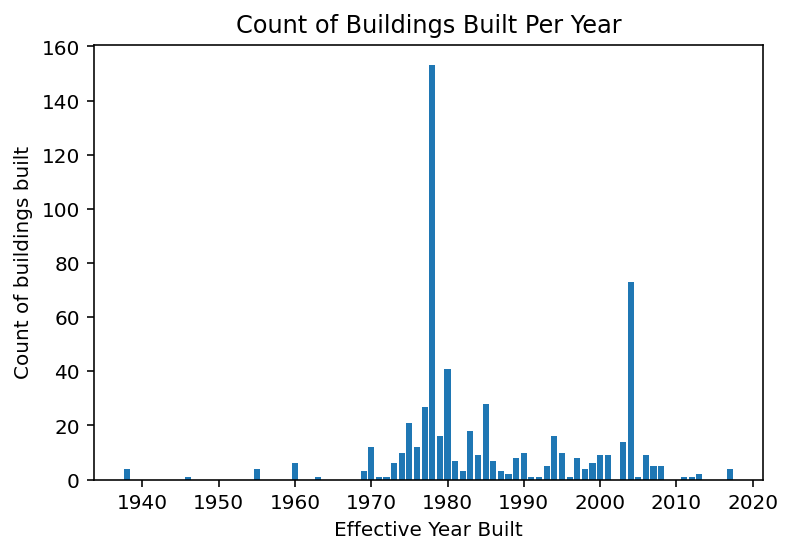

In [523]:
# count of buildings for each year

x = buildings_year.index

fig, ax = plt.subplots()

ax.bar(x, buildings_year['Service Address'])
ax.set_title('Count of Buildings Built Per Year')
ax.set_xlabel('Effective Year Built')
ax.set_ylabel('Count of buildings built')

Text(0, 0.5, 'avg monthly kwh consumed')

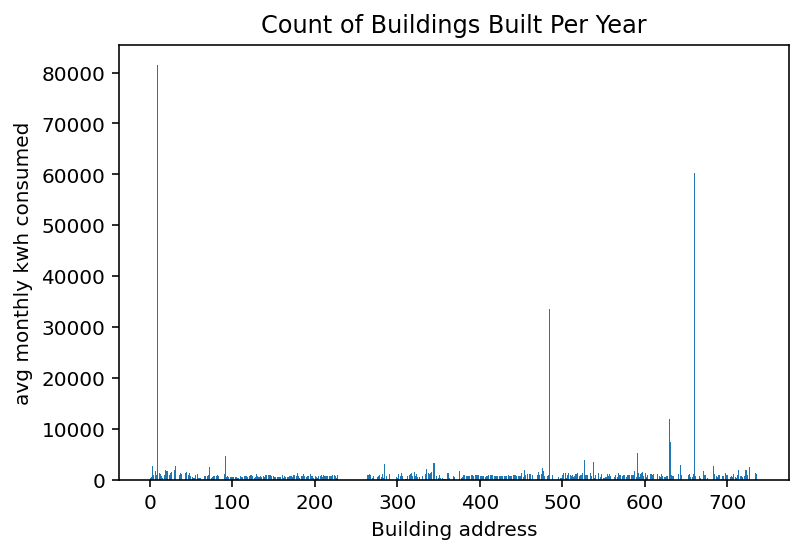

In [525]:
# monthly average kwh consumption (identify outliers)

x = df_kwh_prop_num_copy.index

fig, ax = plt.subplots()

ax.bar(x, df_kwh_prop_num_copy['avg_kwh'])
ax.set_title('Count of Buildings Built Per Year')
ax.set_xlabel('Building address')
ax.set_ylabel('avg monthly kwh consumed')

In [526]:
# select observations with greater than 10,000 avg monthly kwh 

i = df_kwh_prop_num_copy.loc[(df_kwh_prop_num_copy['avg_kwh'] > 10000)].index

In [529]:
# drop outlier with more than 10,000 monthly average kwh
df_kwh_prop_num_copy_ol = df_kwh_prop_num_copy.drop(i, axis=0)

In [530]:
df_kwh_prop_num_copy_ol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594 entries, 1 to 737
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Service Address    594 non-null    object 
 1   avg_kwh            594 non-null    float64
 2   Date               594 non-null    object 
 3   Latitude           594 non-null    float64
 4   Longitude          594 non-null    float64
 5   prop_id            594 non-null    float64
 6   Imprv_ID           594 non-null    float64
 7   Effective_YrBlt    594 non-null    float64
 8   Actual_YrBlt       594 non-null    float64
 9   Bldg_Num           594 non-null    float64
 10  Heated_SquareFeet  594 non-null    float64
 11  StatedArea         594 non-null    float64
 12  LATITUDE           594 non-null    float64
 13  LONGITUDE          594 non-null    float64
 14  POST_CODE          594 non-null    float64
 15  SHAPE_Length       594 non-null    float64
 16  SHAPE_Area         594 non

<h4>Fill in NaN values</h4>

In [531]:
# fill in Nan with median Improvement ID
df_kwh_prop_num['Imprv_ID'] = df_kwh_prop_num['Imprv_ID'].fillna(df_kwh_prop_num['Imprv_ID'].median())

# # fill in Nan with mean Effective Year Built
# df_kwh_prop_num['Effective_YrBlt'] = df_kwh_prop_num['Effective_YrBlt'].fillna(df_kwh_prop_num['Effective_YrBlt'].mean())

# # drop NANs - did so earlier so leaving this here just in case
# df_kwh_prop_num= df_kwh_prop_num.dropna()

# fill in Nan with mean Actual Year Built
df_kwh_prop_num['Actual_YrBlt'] = df_kwh_prop_num['Actual_YrBlt'].fillna(df_kwh_prop_num['Actual_YrBlt'])

# fill in Nan with mean building number
df_kwh_prop_num['Bldg_Num'] = df_kwh_prop_num['Bldg_Num'].fillna(df_kwh_prop_num['Bldg_Num'].mean())

# fill in Nan with mean heated square feet
df_kwh_prop_num['Heated_SquareFeet'] = df_kwh_prop_num['Heated_SquareFeet'].fillna(df_kwh_prop_num['Heated_SquareFeet'].mean())

# fill in Nan with mean heated square feet
df_kwh_prop_num['Heated_SquareFeet'] = df_kwh_prop_num['Heated_SquareFeet'].fillna(df_kwh_prop_num['Heated_SquareFeet'].mean())

# fill in Nan with median stated area
df_kwh_prop_num['StatedArea'] = df_kwh_prop_num['StatedArea'].fillna(df_kwh_prop_num['StatedArea'].median())

# fill in Nan with mean postal code (of owner not service address)
df_kwh_prop_num['POST_CODE'] = df_kwh_prop_num['POST_CODE'].fillna(df_kwh_prop_num['POST_CODE'].mean())

<h4>Create a feature for avg kwh / heated square feet</H4>

In [532]:
df_kwh_prop_num_copy_ol['kwh_per_sqft'] = df_kwh_prop_num_copy_ol['avg_kwh'] / df_kwh_prop_num_copy_ol['Heated_SquareFeet']


In [534]:
# df_kwh_prop_num_copy_ol = df_kwh_prop_num_copy_ol.drop(columns ='kwh_sqft')

In [535]:
df_kwh_prop_num_copy_ol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594 entries, 1 to 737
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Service Address    594 non-null    object 
 1   avg_kwh            594 non-null    float64
 2   Date               594 non-null    object 
 3   Latitude           594 non-null    float64
 4   Longitude          594 non-null    float64
 5   prop_id            594 non-null    float64
 6   Imprv_ID           594 non-null    float64
 7   Effective_YrBlt    594 non-null    float64
 8   Actual_YrBlt       594 non-null    float64
 9   Bldg_Num           594 non-null    float64
 10  Heated_SquareFeet  594 non-null    float64
 11  StatedArea         594 non-null    float64
 12  LATITUDE           594 non-null    float64
 13  LONGITUDE          594 non-null    float64
 14  POST_CODE          594 non-null    float64
 15  SHAPE_Length       594 non-null    float64
 16  SHAPE_Area         594 non

Text(0, 0.5, 'monthly kwh / Heated square foot')

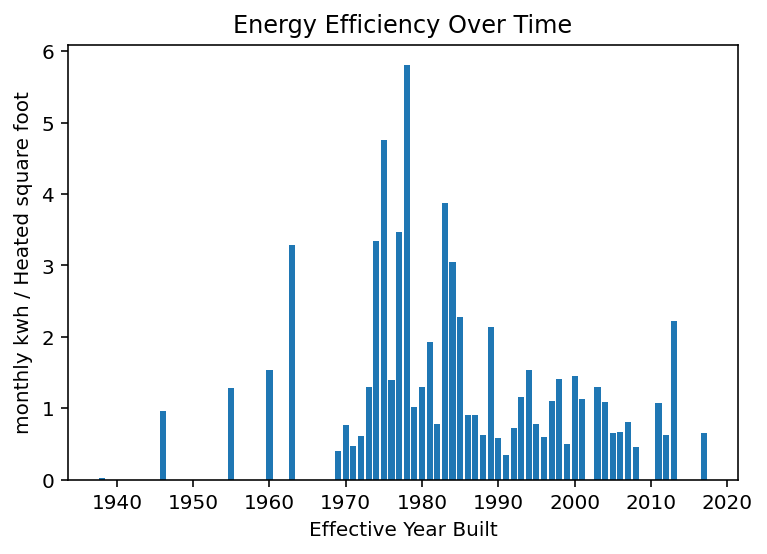

In [536]:
# show avg kwh / heated square feet for each year

x = df_kwh_prop_num_copy_ol['Effective_YrBlt']

fig, ax = plt.subplots()

ax.bar(x, df_kwh_prop_num_copy_ol['kwh_per_sqft'])
ax.set_title('Energy Efficiency Over Time')
ax.set_xlabel('Effective Year Built')
ax.set_ylabel('monthly kwh / Heated square foot')

<h4>Create a feature for building code release years</h4>

In [586]:
df_kwh_prop_num_copy_ol['Effective_YrBlt'] = df_kwh_prop_num_copy_ol['Effective_YrBlt'].astype(int)
type(df_kwh_prop_num_copy_ol['Effective_YrBlt'][3])

numpy.int64

In [660]:
# uniform building code release dates - # 31 total
release_years = [1927, 1935, 1937, 1940, 1943, 1946, 1949, 1952, 1955, 1958, 1961, 1964, 1967, 1970, 1973, 1976, 1979, 1982, 1985, 1988, 1991, 1994, 1997, 2000, 2003, 2006, 2009, 2012, 2015, 2018, 2021]
len(release_years)

# generate a feature column with release numbers corresponding to build dates for each address
def release_year_gen(release_num, build_dates): 
    
    # a list of building code release numbers for each effective build date
    release_lst = []

    for date in build_dates: 
        for tup in release_num: 
            #print(date, tup)
            if date < tup[1]:
                release_lst.append(tup[1])
                break 
    
    return release_lst


In [670]:
release_years = [1927, 1935, 1937, 1940, 1943, 1946, 1949, 1952, 1955, 1958, 1961, 1964, 1967, 1970, 1973, 1976, 1979, 1982, 1985, 1988, 1991, 1994, 1997, 2000, 2003, 2006, 2009, 2012, 2015, 2018, 2021]
release_num = [i for i in enumerate(release_years)]
effective_build_dates = df_kwh_prop_num_copy_ol['Effective_YrBlt']

releases = release_year_gen(release_num, effective_build_dates)

In [671]:
df_kwh_prop_num_copy_ol['code_release'] = releases

In [672]:
df_kwh_prop_num_copy_ol.head()

,Service Address,avg_kwh,Date,Latitude,Longitude,prop_id,Imprv_ID,Effective_YrBlt,Actual_YrBlt,Bldg_Num,Heated_SquareFeet,StatedArea,LATITUDE,LONGITUDE,POST_CODE,SHAPE_Length,SHAPE_Area,kwh_per_sqft,code_release
1,1000 N MAIN ST,288.676190,10/31/2019,29.661106,-82.324533,81291.0,622535.0,1970,1948.0,87306.0,3365.0,0.345,29.661106,-82.321852,32601.0,488.409776,15026.187352,0.085788,1973
2,209 NW 10TH AVE,504.868687,10/31/2019,29.661106,-82.327193,81291.0,622535.0,1970,1948.0,87306.0,3365.0,0.345,29.661106,-82.321852,32601.0,488.409776,15026.187352,0.150035,1973
3,210 NW 10TH AVE,2580.514563,10/31/2019,29.661106,-82.327204,81291.0,622535.0,1970,1948.0,87306.0,3365.0,0.345,29.661106,-82.321852,32601.0,488.409776,15026.187352,0.766869,1973
4,215 1/2 NW 10TH AVE,838.953488,10/31/2019,29.661106,-82.327247,81291.0,622535.0,1970,1948.0,87306.0,3365.0,0.345,29.661106,-82.321852,32601.0,488.409776,15026.187352,0.249318,1973
5,215 NW 10TH AVE,448.740741,01/31/2014,29.661106,-82.327247,81291.0,622535.0,1970,1948.0,87306.0,3365.0,0.345,29.661106,-82.321852,32601.0,488.409776,15026.187352,0.133355,1973


<H4>Export cleaned data</H4>

In [667]:
# export clean data to the clean data dir for use in regression model training
df_kwh_prop_num_copy_ol.to_csv(r'clean-data/kwh_year.csv', header=True)